In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import time

import sys
sys.path.append("../../scripts")

import matplotlib.pyplot as plt
import pandas as pd

from scripts.run_bubblewrap import BubblewrapRun

In [2]:
rng = np.random.default_rng()
np.seterr(all='warn')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Clock w/forgetting
* make a way to compare conditions
* look at c and d magnitudes over time across conditions
* start comparing alternate methods

* ridge regression
* keeping D and c in some range
* periodically recalcualte D

In [465]:
def make_xy(x_max_height=False, fit_intercept=False, keep_dead_nodes=False, y_true_alignment=True, y_tile_invert=True, zscore_x=False, xy_tiles=1, **kwargs):
    with open('../bubblewrap_runs/bubblewrap_run_2023-06-19-11-03-33.pickle', "rb") as fhan:
        br = pickle.load(fhan)
    x_slice_start = 0
    x_slice_end = br.alpha_list.shape[0]
    if y_true_alignment:
        x_slice_start = 1
    if x_max_height:
        x_slice_end = min(x_slice_start + x_max_height, x_slice_end)
    
    node_slice = slice(0,br.alpha_list.shape[1])
    if not keep_dead_nodes:
        node_slice = slice(0,8)
    
    
    X = br.alpha_list[x_slice_start:x_slice_end,node_slice]
    
    if zscore_x:
        X = (X - X.mean(axis=0))/X.std(axis=0)
    
    if fit_intercept:
        X = np.hstack([X, np.ones(shape=[X.shape[0],1])])
    
    y = np.load('../datasets/clock-steadier_farther.npz')['x']
    if y_tile_invert:
        y = np.hstack([y, -y, y]).reshape((-1,1))
    else:
        y = np.hstack([y, y, y]).reshape((-1,1))
    y = y[:X.shape[0]]
    
    
    X = np.tile(X, reps=(xy_tiles,1))
    y = np.tile(y, reps=(xy_tiles,1))
    return X, y

In [145]:
def regress_online_more(X, y, m=50, forgetting_factor=1, log_extra=True, **kwargs):
    logger = dict(d_hist=[], c_hist=[], w_hist=[], pred_hist=[], i_hist=[], d_recal_hist=[], pred_recal_hist=[], pred_lstsq_hist=[], w_recal_hist=[])
    start = time.time()
    
    c = X[:m].T @ y[:m]
    F = X[:m].T @ X[:m]
    D = np.linalg.inv(F)
    for i in (np.arange(0,X.shape[0])):
        if i >= m:
            # get most recent timepoint
            x = X[i:i+1,:].T

            # modify by forgetting factors
            D = D / forgetting_factor 
            c = c * forgetting_factor
            F = F * forgetting_factor
            
            # update c and D
            D = D - (D @ x @ x.T @ D)/(1 + x.T @ D @ x)
            c = c  + x * y[i]
            F = F + x@x.T
            
            
            # logging
            if log_extra:
                F_pinv = np.linalg.pinv(F)
                logger['d_hist'].append(D)
                logger['c_hist'].append(c)
                logger['d_recal_hist'].append(F_pinv)
                
            logger['i_hist'].append(i)
            w = D @ c
            logger['w_hist'].append(w)
            logger['pred_hist'].append(X[i,:]@ D @ c)
            if log_extra:
                logger['w_recal_hist'].append(F_pinv @ c)

                logger['pred_recal_hist'].append(X[i,:] @ F_pinv @ c)
                logger['pred_lstsq_hist'].append(X[i,:] @ np.linalg.lstsq(F, c, rcond=None)[0])
    end = time.time()
    for key in logger:
        logger[key] = np.squeeze(logger[key])
    logger['time'] = end-start

    logger['y_hist'] = y[logger['i_hist']]
    return logger

In [322]:
def regress_online_dirty(X, y, m=50, forgetting_factor=1, noise_scale=0,log_extra=True, **kwargs):
    logger = dict(d_hist=[], c_hist=[], w_hist=[], pred_hist=[], i_hist=[], d_recal_hist=[], pred_recal_hist=[], pred_lstsq_hist=[], w_recal_hist=[])
    start = time.time()
    
    Xm = X[:m] 
    Xm += rng.normal(scale = 1e-5, size=Xm.shape)
    c = Xm.T @ y[:m]
    F = Xm.T @ Xm
    D = np.linalg.pinv(F)
    for i in (np.arange(0,X.shape[0])):
        if i >= m:
            # get most recent timepoint
            x = X[i:i+1,:].T
            x += rng.normal(scale = noise_scale, size=x.shape)

            # modify by forgetting factors
            D = D / forgetting_factor 
            c = c * forgetting_factor
            F = F * forgetting_factor
            
            # update c and D
            D = D - (D @ x @ x.T @ D)/(1 + x.T @ D @ x)
            c = c  + x * y[i]
            F = F + x@x.T
            
            
            # logging
            
            logger['i_hist'].append(i)
            logger['pred_hist'].append(X[i,:]@ D @ c)


            w = D @ c
            logger['w_hist'].append(w)
            
            if log_extra:
                F_pinv = np.linalg.pinv(F)
                logger['d_hist'].append(D)
                logger['c_hist'].append(c)

                logger['d_recal_hist'].append(F_pinv)            
                logger['w_recal_hist'].append(F_pinv @ c)
                logger['pred_recal_hist'].append(X[i,:] @ F_pinv @ c)
                logger['pred_lstsq_hist'].append(X[i,:] @ np.linalg.lstsq(F, c, rcond=None)[0])
    end = time.time()
    for key in logger:
        logger[key] = np.squeeze(logger[key])
    logger['time'] = end-start
    logger['y_hist'] = y[logger['i_hist']]
    return logger

In [467]:
def regress_online_dirty_symmetric(X, y, m=50, forgetting_factor=1, noise_scale=0,log_extra=True, **kwargs):
    logger = dict(d_hist=[], c_hist=[], w_hist=[], pred_hist=[], i_hist=[], d_recal_hist=[], pred_recal_hist=[], pred_lstsq_hist=[], w_recal_hist=[])
    start = time.time()
    
    Xm = X[:m] 
    Xm += rng.normal(scale = noise_scale, size=Xm.shape)
    c = Xm.T @ y[:m]
    F = Xm.T @ Xm
    D = np.linalg.pinv(F)
    for i in (np.arange(0,X.shape[0])):
        if i >= m:
            # get most recent timepoint
            x0 = X[i:i+1,:].T
            dx = rng.normal(scale = noise_scale, size=x0.shape)
            D = D / forgetting_factor 
            c = c * forgetting_factor
            F = F * forgetting_factor
            
            for j in range(2):
                x = x0 + dx if j==0 else x0 - dx
                # modify by forgetting factors


                # update c and D
                D = D - (D @ x @ x.T @ D)/(1 + x.T @ D @ x)
                c = c  + x * y[i]
                F = F + x@x.T
            
            
            # logging
            
            logger['i_hist'].append(i)
            logger['pred_hist'].append(X[i,:]@ D @ c)


            w = D @ c
            logger['w_hist'].append(w)
            
            if log_extra:
                F_pinv = np.linalg.pinv(F)
                logger['d_hist'].append(D)
                logger['c_hist'].append(c)

                logger['d_recal_hist'].append(F_pinv)            
                logger['w_recal_hist'].append(F_pinv @ c)
                logger['pred_recal_hist'].append(X[i,:] @ F_pinv @ c)
                logger['pred_lstsq_hist'].append(X[i,:] @ np.linalg.lstsq(F, c, rcond=None)[0])
    end = time.time()
    for key in logger:
        logger[key] = np.squeeze(logger[key])
    logger['time'] = end-start
    logger['y_hist'] = y[logger['i_hist']]
    return logger

In [380]:
def regress_online_window(X, y, m=50, window_length=50, forgetting_factor=1, log_extra=True, **kwargs):
    logger = dict(d_hist=[], c_hist=[], w_hist=[], pred_hist=[], i_hist=[], d_recal_hist=[], pred_recal_hist=[], pred_lstsq_hist=[], w_recal_hist=[])
    start = time.time()
    
    window = list(X[:m])
    y_history = list(y[:m])
    F = X[:m].T @ X[:m]
    # D = np.linalg.inv(F)
    for i in (np.arange(m,X.shape[0])):
        # get most recent timepoint
        x = X[i:i+1,:].T

        # modify by forgetting factors
        # D = D / forgetting_factor 
        # c = c * forgetting_factor
        F = F * forgetting_factor

        # update c and D
        if len(window) > window_length:
            window.pop(0)
            y_history.pop(0)
        for j in range(len(window)):
            window[j] *= forgetting_factor
            y_history[j] = y_history[j] * forgetting_factor
        
        window.append(X[i])
        y_history.append(y[i,0])
        win = np.array(window)

        D = np.linalg.pinv(win.T @ win)

        c = 0
        for j in range(len(window)):
            c += y_history[j] * window[j]
        F = F + x@x.T
        

        # logging

        logger['i_hist'].append(i)


        w = D @ c
        logger['pred_hist'].append(X[i,:]@ D @ c)
        
        if log_extra:
            F_pinv = np.linalg.pinv(F)
            logger['d_hist'].append(D)
            logger['c_hist'].append(c)
            logger['d_recal_hist'].append(F_pinv)
            logger['w_hist'].append(w)
            logger['w_recal_hist'].append(F_pinv @ c)
            
            logger['pred_recal_hist'].append(X[i,:] @ F_pinv @ c)
            logger['pred_lstsq_hist'].append(X[i,:] @ np.linalg.lstsq(F, c, rcond=None)[0])
    end = time.time()
    for key in logger:
        logger[key] = np.squeeze(logger[key])
    logger['time'] = end-start
    logger['y_hist'] = y[logger['i_hist']]
    return logger

In [483]:
def regress_online_window_fast(X, y, m=50, window_length=50, forgetting_factor=1, log_extra=True, **kwargs):
    logger = dict(d_hist=[], c_hist=[], w_hist=[], pred_hist=[], i_hist=[], d_recal_hist=[], pred_recal_hist=[], pred_lstsq_hist=[], w_recal_hist=[])
    start = time.time()
    
    window = list(X[:m])
    y_history = list(y[:m])
    F = X[:m].T @ X[:m]
    
    # D = np.linalg.inv(F)
    for i in (np.arange(m,X.shape[0])):
        # get most recent timepoint
        x = X[i:i+1,:].T

        # modify by forgetting factors
        # D = D / forgetting_factor 
        # c = c * forgetting_factor
        F = F * forgetting_factor

        # update c and D
        if len(window) > window_length:
            window.pop(0)
            y_history.pop(0)
        for j in range(len(window)):
            window[j] *= forgetting_factor
            y_history[j] = y_history[j] * forgetting_factor
        
        window.append(X[i])
        y_history.append(y[i,0])
        win = np.array(window)

        D = np.linalg.pinv(win.T @ win)

        c = 0
        for j in range(len(window)):
            c += y_history[j] * window[j]
        F = F + x@x.T
        

        # logging

        logger['i_hist'].append(i)


        w = D @ c
        logger['pred_hist'].append(X[i,:]@ D @ c)
        
        if log_extra:
            F_pinv = np.linalg.pinv(F)
            logger['d_hist'].append(D)
            logger['c_hist'].append(c)
            logger['d_recal_hist'].append(F_pinv)
            logger['w_hist'].append(w)
            logger['w_recal_hist'].append(F_pinv @ c)
            
            logger['pred_recal_hist'].append(X[i,:] @ F_pinv @ c)
            logger['pred_lstsq_hist'].append(X[i,:] @ np.linalg.lstsq(F, c, rcond=None)[0])
    end = time.time()
    for key in logger:
        logger[key] = np.squeeze(logger[key])
    logger['time'] = end-start
    logger['y_hist'] = y[logger['i_hist']]
    return logger

In [324]:
def regress_online_more_eecs_paper(X, y, m=50, forgetting_factor=1, log_extra=False, noise_scale=0, **kwargs):
    logger = dict(d_hist=[], c_hist=[], w_hist=[], pred_hist=[], i_hist=[], d_recal_hist=[], pred_recal_hist=[], pred_lstsq_hist=[])
    start = time.time()
    
    c = X[:m].T @ y[:m]
    F = X[:m].T @ X[:m]
    D = np.linalg.pinv(F)
    # w = np.zeros((X.shape[1],1))
    w = np.linalg.lstsq(F, c, rcond=None)[0]
    for i in (np.arange(0,X.shape[0])):
        if i >= m:
            # get most recent timepoint
            x = X[i:i+1,:].T
            x += rng.normal(scale = noise_scale, size=x.shape)

            g = D @ x
            alpha = 1/np.squeeze(forgetting_factor + x.T @ g)
            e = y[i] - np.squeeze(w.T @ x)

            
            
            
            # update c and D
            D = (1/forgetting_factor) * D - (1/forgetting_factor) * alpha * g @ g.T
            w = w + alpha * g * e
            c = c  + x * y[i]
            F = F + x@x.T
            
            
            # logging
            
            logger['i_hist'].append(i)
            logger['pred_hist'].append(X[i,:]@ w)
            
            if log_extra:
                F_pinv = np.linalg.pinv(F)
                logger['d_hist'].append(D)
                logger['c_hist'].append(c)
                logger['d_recal_hist'].append(F_pinv)

                logger['w_hist'].append(w)

                logger['pred_recal_hist'].append(X[i,:] @ F_pinv @ c)
                logger['pred_lstsq_hist'].append(X[i,:] @ np.linalg.lstsq(F, c, rcond=None)[0])
    end = time.time()
    for key in logger:
        logger[key] = np.squeeze(logger[key])
    logger['time'] = end-start
    logger['y_hist'] = y[logger['i_hist']]
    return logger

In [276]:
def mpi_rank1_update(D,F,x):
    ε = 1e-15# 03b5

    beta = (1 + x.T @ D @ x)[0,0]
    v = D @ x
    n = D.T @ x
    w = (np.eye(D.shape[0]) - F @ D) @ x
    m = (np.eye(D.shape[0]) - D @ F).T @ x

    lw = np.linalg.norm(w)
    lm = np.linalg.norm(m)
    lv = np.linalg.norm(v)
    ln = np.linalg.norm(n)

    if lw > ε and lm > ε:
        case = 0
        G = -1 * v @ w.T/(lw**2)  - m @ n.T/(lm**2) + beta * m @ w.T/(lm**2 * lw**2)
    elif lw < ε and lm > ε and beta < ε:
        case = 1 
        G = -1/lv**2 * v @ v.T @ D - 1/lm**2 * m @ n.T
    elif lw < ε and beta > ε:
        case = 2
        G = 1/beta * m @ v.T @ D - beta/(lv**2 * lm**2 + np.abs(beta)**2) * ( lv**2/beta * m + v  ) @ (lm**2/beta* D.T @ v + n ).T
    elif lw > ε and lm < ε and beta < ε:
        case = 3
        G = -1/ln**2 * D @ n @ n.T - 1/lw**2 * v @ w.T
    elif lm < ε and beta > ε:
        case = 4 
        G = 1/beta * D @ n @ w.T - beta/(ln**2 * lw**2 + np.abs(beta)**2) * ( lw**2/beta * D @n + v  ) @ (ln**2/beta*w + n ).T
    elif lw < ε and lm < ε and beta < ε:
        case = 5
        G = -1/lv**2 * v @ v.T @ D - 1/ln**2 * D @ n @ n.T + (v.T @ D @ n)/(lv**2 * ln**2) * v @ n.T 
    else:
        # look in the matrix cookbook section 3.7.2
        raise NotImplementedError()
        
        
    return D + G, np.array([lw, lm, beta]), case


def regress_online_pinv(X, y, m=50, forgetting_factor=1, log_extra=True, **kwargs):
    logger = dict(d_hist=[], c_hist=[], w_hist=[], pred_hist=[], i_hist=[], d_recal_hist=[], pred_recal_hist=[], pred_lstsq_hist=[], diagnostics=[], f_hist=[], case=[])
    start = time.time()
    
    c = X[:m].T @ y[:m]
    F = X[:m].T @ X[:m]
    D = np.linalg.pinv(F)
    for i in (np.arange(0,X.shape[0])):
        if i >= m:
            # get most recent timepoint
            x = X[i:i+1,:].T
            # x += rng.normal(scale = 1e-5, size=x.shape)

            # modify by forgetting factors
            D = D / forgetting_factor 
            c = c * forgetting_factor
            F = F * forgetting_factor
            
            # update c and D
            D, diagnostics, case = mpi_rank1_update(D, F, x)
            c = c  + x * y[i]
            F = F + x @ x.T
            
            
            # logging
            
            logger['case'].append(case)
            logger['i_hist'].append(i)
            
            w = D @ c
            
            logger['pred_hist'].append(X[i,:]@ D @ c)
            
            if log_extra:
                logger['w_hist'].append(w)
                logger['diagnostics'].append(diagnostics)
                logger['d_hist'].append(D)
                logger['c_hist'].append(c)
                logger['f_hist'].append(F)
                logger['d_recal_hist'].append(np.linalg.inv(F))
                logger['pred_recal_hist'].append(X[i,:] @ np.linalg.pinv(F) @ c)
                logger['pred_lstsq_hist'].append(X[i,:] @ np.linalg.lstsq(F, c, rcond=None)[0])
    end = time.time()
    for key in logger:
        logger[key] = np.squeeze(logger[key])
    logger['time'] = end-start
    logger['y_hist'] = y[logger['i_hist']]
    return logger

In [281]:
def mpi_rank1_oracular_update(D,F,x):
    beta = (1 + x.T @ D @ x)[0,0]
    v = D @ x
    n = D.T @ x
    w = (np.eye(D.shape[0]) - F @ D) @ x
    m = (np.eye(D.shape[0]) - D @ F).T @ x

    lw = np.linalg.norm(w)
    lm = np.linalg.norm(m)
    lv = np.linalg.norm(v)
    ln = np.linalg.norm(n)

    gs = []
    gs.append(-1 * v @ w.T/(lw**2)  - m @ n.T/(lm**2) + beta * m @ w.T/(lm**2 * lw**2))
    gs.append(-1/lv**2 * v @ v.T @ D - 1/lm**2 * m @ n.T)
    gs.append(1/beta * m @ v.T @ D - beta/(lv**2 * lm**2 + np.abs(beta)**2) * ( lv**2/beta * m + v  ) @ (lm**2/beta* D.T @ v + n ).T)
    gs.append(-1/ln**2 * D @ n @ n.T - 1/lw**2 * v @ w.T)
    gs.append(1/beta * D @ n @ w.T - beta/(ln**2 * lw**2 + np.abs(beta)**2) * ( lw**2/beta * D @n + v  ) @ (ln**2/beta*w + n ).T)
    gs.append(-1/lv**2 * v @ v.T @ D - 1/ln**2 * D @ n @ n.T + (v.T @ D @ n)/(lv**2 * ln**2) * v @ n.T)
    
    return np.array(gs), np.array([lw, lm, beta])


def regress_online_pinv_oracle(X, y, m=50, forgetting_factor=1, log_extra=True, **kwargs):
    logger = dict(d_hist=[], c_hist=[], w_hist=[], pred_hist=[], i_hist=[], d_recal_hist=[], pred_recal_hist=[], pred_lstsq_hist=[], diagnostics=[], f_hist=[], choices=[])
    start = time.time()
    
    c = X[:m].T @ y[:m]
    F = X[:m].T @ X[:m]
    D = np.linalg.pinv(F)
    for i in (np.arange(0,X.shape[0])):
        if i >= m:
            # get most recent timepoint
            x = X[i:i+1,:].T
            # x += rng.normal(scale = 1e-10, size=x.shape)

            # modify by forgetting factors
            D = D / forgetting_factor 
            c = c * forgetting_factor
            F = F * forgetting_factor
            
            # update c and D
            gs, diagnostics = mpi_rank1_oracular_update(D, F, x)
            
            D_pinv = np.linalg.pinv(F)
            
            errors = (((D + gs) - D_pinv)**2).sum(axis=1).sum(axis=1)
            choice = np.argmin(errors)
            D = D + gs[choice,:,:]
            
            c = c  + x * y[i]
            F = F + x @ x.T
            
            
            # logging
            logger['choices'].append(choice)
            logger['i_hist'].append(i)
            w = D @ c
            
            logger['pred_hist'].append(X[i,:]@ D @ c)
            
            if log_extra:
                logger['w_hist'].append(w)
                logger['diagnostics'].append(diagnostics)

                logger['d_hist'].append(D)
                logger['c_hist'].append(c)
                logger['f_hist'].append(F)
                logger['d_recal_hist'].append(np.linalg.pinv(F))


                logger['pred_recal_hist'].append(X[i,:] @ D_pinv @ c)
                logger['pred_lstsq_hist'].append(X[i,:] @ np.linalg.lstsq(F, c, rcond=None)[0])
    end = time.time()
    for key in logger:
        logger[key] = np.squeeze(logger[key])
    logger['time'] = end-start
    logger['y_hist'] = y[logger['i_hist']]
    return logger

In [482]:
def make_easier_xy(**kwargs):
    
    m = 5000
    n = 5
    
    w = np.array([0, 0, 0, 1, 0]).reshape((-1,1))
    
    X = np.zeros(shape=(m,n))
    y = np.zeros(shape=(m,1))
    for i in range(m):
        X[i,:] = rng.normal(size=5)
    y = X @ w + rng.normal(size=(X.shape[0],1))
    
    X = np.hstack([X, X])
    
    return X, y

In [480]:
uninteresting_params = dict(
    x_max_height=False, 
    y_true_alignment=True, 
    y_tile_invert=True, 
    zscore_x=False,
    m=100,
    xy_tiles=1,
)
params = dict(uninteresting_params,
    fit_intercept=True, 
    keep_dead_nodes=True,
    forgetting_factor=.98,
    log_extra=False,
    noise_scale=1e-5,
    window_length=50
)


functions = [
    # regress_online_dirty,
    regress_online_dirty_symmetric,
    regress_online_window,
    # regress_online_more,
    # regress_online_more_eecs_paper,
    # regress_online_pinv,
    # regress_online_pinv_oracle,
    
]

X, y = make_xy(**params)
errs = []
logs = []
for f in tqdm(functions):
    log = f(X,y, **params)
    logs.append(log)
    err = log['pred_hist'] - log['y_hist'][:,0]
    sqe = (err**2).sum()
    errs.append(err)


100%|█████████████████████████████████████████████| 2/2 [00:13<00:00,  6.75s/it]


In [481]:
%matplotlib qt
for e in errs:
    plt.plot(e)

In [477]:
%matplotlib qt
for e in errs:
    plt.hist(e, bins=np.linspace(-.06,.06,100), histtype='step')

In [471]:
%matplotlib qt
plt.plot([(e**2).mean() for e in errs])

In [473]:
j = 0
plt.plot(logs[j]['y_hist'])
plt.plot(logs[j]['pred_hist'])


### Old Comparisons 

In [394]:
uninteresting_params = dict(
    x_max_height=False, 
    y_true_alignment=False, 
    y_tile_invert=True, 
    zscore_x=False,
    m=100,
    xy_tiles=1,
)

def do_run(params):
    X, y = make_xy(**params)
    # log = regress_online_more(X,y, **params)
    # log = regress_online_more_eecs_paper(X,y, **params)
    # log = regress_online_pinv_oracle(X,y, **params)
    # log = regress_online_window(X,y, **params)
    log = regress_online_dirty(X,y, **params)
    log['error'] = log['pred_hist'] - log['y_hist']
    log['sqe'] = (log['error']**2).sum()
    return log

params1 = dict(uninteresting_params,
    fit_intercept=True, 
    keep_dead_nodes=True,
    forgetting_factor=1,
    log_extra=False,

)

params2 = dict(params1, forgetting_factor=1)

log1 = do_run(params1)
log2 = do_run(params2)

In [ ]:
def make_label(params):
    return f"+b? {int(params['fit_intercept'])}, ☠? {int(params['keep_dead_nodes'])}, f.f.={params['forgetting_factor']}"

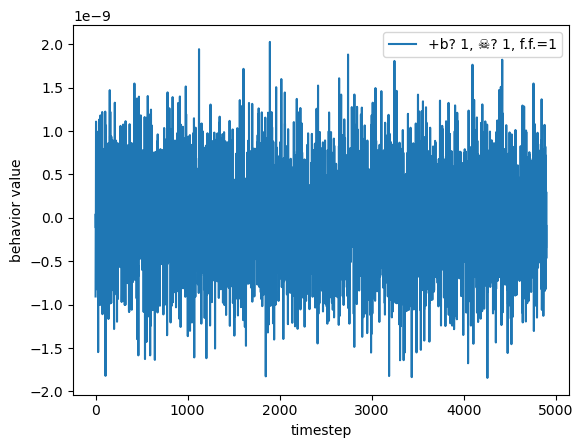

In [165]:
# compare log1 and log2
# plt.plot(log1['y_hist'], label='true y')
plt.plot(log1['pred_hist'] - np.squeeze(log1['y_hist']), label=make_label(params1))
# plt.plot(log2['pred_hist'] - np.squeeze(log2['y_hist']), label=make_label(params2))
plt.xlabel("timestep");
plt.ylabel("behavior value");
plt.legend();


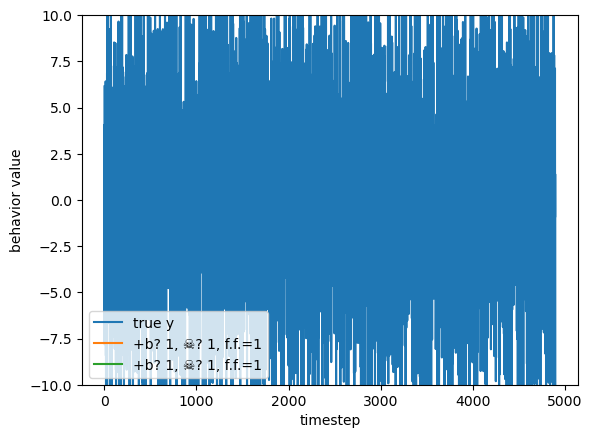

In [143]:
# compare log1 and log2
plt.plot(log1['y_hist'], label='true y')
plt.plot(log1['pred_hist'], label=make_label(params1))
plt.plot(log2['pred_hist'], label=make_label(params2))
plt.xlabel("timestep");
plt.ylabel("behavior value");
plt.ylim([-10,10])
plt.legend();

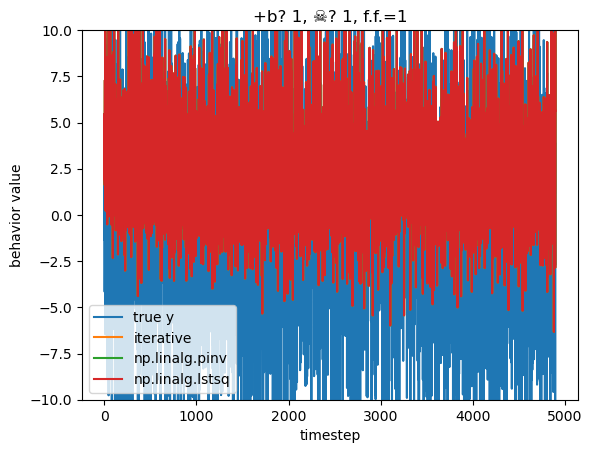

In [73]:
# compare pred_hist and pred_recal_list
plt.plot(log2['y_hist'], label='true y')
plt.plot(log2['pred_hist'], label="iterative")
plt.plot(log2['pred_recal_hist'], label="np.linalg.pinv")
plt.plot(log2['pred_lstsq_hist'], label="np.linalg.lstsq")
plt.xlabel("timestep");
plt.ylabel("behavior value");
plt.ylim([-10,10])
plt.title(make_label(params2))
plt.legend();

In [109]:
a,b = 0,0

errors = ((log2['d_hist'] - log2['d_recal_hist'])**2).sum(axis=0)
a,b = np.unravel_index(errors.argmax(), errors.shape)

plt.plot(log2['d_hist'][:,0,0], label="iterative");
plt.plot(log2['d_recal_hist'][:,0,0], label="np.linalg.inv");

plt.title(f"D[{a},{b}];  " + make_label(params2))

plt.legend()

/tmp/ipykernel_42093/3844783392.py:3: RuntimeWarning: overflow encountered in square
  errors = ((log2['d_hist'] - log2['d_recal_hist'])**2).sum(axis=0)
/home/jgould/miniconda3/envs/bubblewrap/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [110]:
plt.plot(np.log10(log2['diagnostics']))

KeyError: 'diagnostics'

In [ ]:
plt.plot(log2['choices'],'.')

In [111]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)

uppers = np.max(np.abs(log2['d_hist']), axis=(1,2))
lowers = np.min(np.abs(log2['d_hist']), axis=(1,2))
axs[0].plot(np.log10(uppers), label='upper limit')
axs[0].plot(np.log10(lowers),  label='lower limit')
axs[0].set_xlabel("timestep")
axs[0].set_ylabel("log10 $\mid D\mid $bounds (streaming)")
axs[0].legend()


uppers = np.max(np.abs(log2['d_recal_hist']), axis=(1,2))
lowers = np.min(np.abs(log2['d_recal_hist']), axis=(1,2))
axs[1].plot(np.log10(uppers))
axs[1].plot(np.log10(lowers))
axs[1].set_xlabel("timestep")
axs[1].set_ylabel("log10 $\mid D\mid $bounds (pinv)")


axs[0].set_title(make_label(params2));

In [113]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)

uppers = np.max(np.abs(log2['w_hist']), axis=(1))
lowers = np.min(np.abs(log2['w_hist']), axis=(1))
axs[0].plot(np.log10(uppers), label='upper limit')
axs[0].plot(np.log10(lowers),  label='lower limit')
axs[0].set_xlabel("timestep")
axs[0].set_ylabel("log10 $\mid D\mid $bounds (streaming)")
axs[0].legend()


uppers = np.max(np.abs(log2['w_recal_hist']), axis=(1))
lowers = np.min(np.abs(log2['w_recal_hist']), axis=(1))
axs[1].plot(np.log10(uppers))
axs[1].plot(np.log10(lowers))
axs[1].set_xlabel("timestep")
axs[1].set_ylabel("log10 $\mid D\mid $bounds (pinv)")


axs[0].set_title(make_label(params2));

KeyError: 'w_recal_hist'

In [68]:
df = []

for d in [False, True]:
    for i in [False,True]:
        X,y = make_xy(fit_intercept=i, keep_dead_nodes=d)
        df.append(dict(intercept=i, dead_nodes=d, condition_number=np.linalg.cond(X)))
df = pd.DataFrame(df)
df

,intercept,dead_nodes,condition_number
0,False,False,1.003606e+00
1,True,False,1.396301e+05
2,False,True,4.225899e+16
3,True,True,1.266425e+17


)compare ws across runs over time

compare online predictions across time

inspect d's entries across time

In [48]:
rows = []
for keep_dead_nodes in [False, True]:
    for fit_intercept in [False, True]:
        for eps in [0, 1e-10, 1e-3, 1e-2, 1e-1]:
            interesting_params = dict(fit_intercept=fit_intercept, keep_dead_nodes=keep_dead_nodes, forgetting_factor=1-eps)
            params = dict(uninteresting_params,**interesting_params)
            
            X, y = make_xy(**params)
            # log = regress_online_more(X,y, **params)
            log = regress_online_more_eecs_paper(X,y, **params)
            # log = regress_online_pinv_oracle(X,y, **params)
            # log = regress_online_pinv(X,y, **params)
            # log = regress_online_window(X,y, **params)
            # log = regress_online_dirty(X,y, **params)
            log['error'] = log['pred_hist'] - log['y_hist'].reshape([-1,])
            log['sqe'] = (log['error']**2).sum()
            rows.append(dict(interesting_params,method="online_vanilla",error=log['error']))
            print(interesting_params)
            # if np.any(np.abs(log['error']) > 30) or np.any(~np.isfinite(log['error'])):
            #     raise Exception()
            



{'fit_intercept': False, 'keep_dead_nodes': False, 'forgetting_factor': 1}
{'fit_intercept': False, 'keep_dead_nodes': False, 'forgetting_factor': 0.9999999999}
{'fit_intercept': False, 'keep_dead_nodes': False, 'forgetting_factor': 0.999}


/tmp/ipykernel_6469/297464630.py:24: RuntimeWarning: overflow encountered in subtract
  D = (1/forgetting_factor) * D - (1/forgetting_factor) * alpha * g @ g.T
/tmp/ipykernel_6469/297464630.py:24: RuntimeWarning: invalid value encountered in multiply
  D = (1/forgetting_factor) * D - (1/forgetting_factor) * alpha * g @ g.T
/tmp/ipykernel_6469/297464630.py:24: RuntimeWarning: invalid value encountered in matmul
  D = (1/forgetting_factor) * D - (1/forgetting_factor) * alpha * g @ g.T
/tmp/ipykernel_6469/297464630.py:25: RuntimeWarning: invalid value encountered in multiply
  w = w + alpha * g * e


{'fit_intercept': False, 'keep_dead_nodes': False, 'forgetting_factor': 0.99}
{'fit_intercept': False, 'keep_dead_nodes': False, 'forgetting_factor': 0.9}
{'fit_intercept': True, 'keep_dead_nodes': False, 'forgetting_factor': 1}
{'fit_intercept': True, 'keep_dead_nodes': False, 'forgetting_factor': 0.9999999999}
{'fit_intercept': True, 'keep_dead_nodes': False, 'forgetting_factor': 0.999}
{'fit_intercept': True, 'keep_dead_nodes': False, 'forgetting_factor': 0.99}


/tmp/ipykernel_6469/297464630.py:24: RuntimeWarning: overflow encountered in multiply
  D = (1/forgetting_factor) * D - (1/forgetting_factor) * alpha * g @ g.T
/tmp/ipykernel_6469/297464630.py:16: RuntimeWarning: invalid value encountered in matmul
  g = D @ x


{'fit_intercept': True, 'keep_dead_nodes': False, 'forgetting_factor': 0.9}
{'fit_intercept': False, 'keep_dead_nodes': True, 'forgetting_factor': 1}
{'fit_intercept': False, 'keep_dead_nodes': True, 'forgetting_factor': 0.9999999999}
{'fit_intercept': False, 'keep_dead_nodes': True, 'forgetting_factor': 0.999}


/tmp/ipykernel_6469/297464630.py:24: RuntimeWarning: overflow encountered in matmul
  D = (1/forgetting_factor) * D - (1/forgetting_factor) * alpha * g @ g.T


{'fit_intercept': False, 'keep_dead_nodes': True, 'forgetting_factor': 0.99}
{'fit_intercept': False, 'keep_dead_nodes': True, 'forgetting_factor': 0.9}


KeyboardInterrupt: 

In [49]:
df = pd.DataFrame(rows)
df["mse"] = [((x)**2).mean() for x in df.error]
df

,fit_intercept,keep_dead_nodes,forgetting_factor,method,error,mse
0,False,False,1.000,online_vanilla,"[3.758481761373389e-06, 0.00013123682025284467...",1.559859e+01
1,False,False,1.000,online_vanilla,"[-7.163353239914017e-05, 3.263172677581139e-05...",1.559859e+01
2,False,False,0.999,online_vanilla,"[0.00015089210527774455, -2.483193472446743e-0...",1.002318e+03
3,False,False,0.990,online_vanilla,"[-1.6418888135749654e-05, 4.600812358646067e-0...",NaN
4,False,False,0.900,online_vanilla,"[1.0609201213096497e-05, -4.702462959027542e-0...",NaN
5,True,False,1.000,online_vanilla,"[0.0001921817060632769, -7.167923911266527e-05...",1.559810e+01
6,True,False,1.000,online_vanilla,"[9.582639444172258e-05, 0.00018727674054019872...",1.559765e+01
7,True,False,0.999,online_vanilla,"[-6.599540851892627e-05, 8.892832179974164e-06...",2.924349e+05
8,True,False,0.990,online_vanilla,"[1.9944337552146862e-05, 0.0001674907214033183...",9.215743e-08
9,True,False,0.900,online_vanilla,"[6.038646835415662e-05, -3.0838848630310167e-0...",NaN


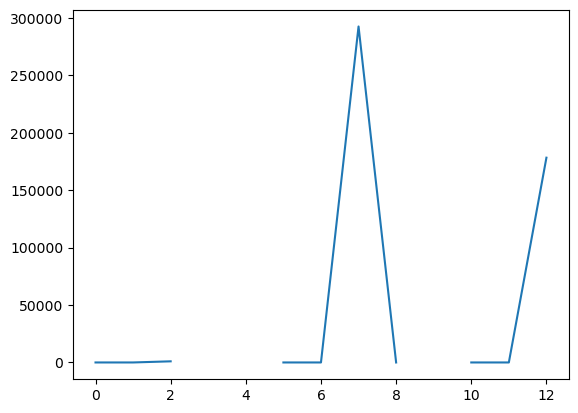

In [50]:
plt.plot(df.mse[:])

# MPI update

In [204]:
def mpi_rank1_update(D,F,x):
    beta = (1 + x.T @ D @ x)[0,0]
    v = D @ x
    n = D.T @ x
    w = (np.eye(D.shape[0]) - F @ D) @ x
    m = (np.eye(D.shape[0]) - D @ F).T @ x
    
    lw = np.linalg.norm(w)
    lm = np.linalg.norm(m)
    print(beta)
    
    if lw > 0 and lm > 0:
        G = -1 * v @ w.T/(lw**2)  - m @ n.T/(lm**2) + beta * m @ w.T/(lm**2 * lw**2)
    elif lm < 1e-10 and beta > 1e-10:
        print('hit')
        ln = numpy.linalg.norm(n)
        G = 1/beta * D @ n @ w.T - beta/(ln**2 * lw**2 + np.abs(beta)**2) * ( lw**2/beta * D @n + v  ) @ (ln**2/beta*w + n ).T
    else:
        # look in the matrix cookbook section 3.7.2
        raise NotImplementedError()
    
    
    return D + G

In [205]:
# simulates the creation of D and F=((C^T)C)

d = 10
F = np.zeros(shape=(2*d,2*d))

for i in range(100):
    x1 = rng.normal(size=(d,1))
    x2 = rng.normal(size=(d,1)) * 1e-20
    x = np.vstack([x1, x2])
    F = F + x @ x.T

D = np.linalg.pinv(F)

x1 = rng.normal(size=(d,1))
x2 = rng.normal(size=(d,1)) * 1e-20
x = np.vstack([x1, x2])

In [202]:
t = 5_000
D = log2['d_hist'][t]
F = log2['f_hist'][t]
x = make_xy(**params2)[0][t,:,None]


KeyError: 'f_hist'

In [206]:
ε = 1e-10 # 03b5

beta = (1 + x.T @ D @ x)[0,0]
v = D @ x
n = D.T @ x
w = (np.eye(D.shape[0]) - F @ D) @ x
m = (np.eye(D.shape[0]) - D @ F).T @ x

lw = np.linalg.norm(w)
lm = np.linalg.norm(m)
lv = np.linalg.norm(v)
ln = np.linalg.norm(n)


if lw > ε and lm > ε:
    print("case 0")
    G = -1 * v @ w.T/(lw**2)  - m @ n.T/(lm**2) + beta * m @ w.T/(lm**2 * lw**2)
elif lw < ε and lm > ε and beta < ε:
    print("case 1")
    G = -1/lv**2 * v @ v.T @ D - 1/lm**2 * m @ n.T
elif lw < ε and beta > ε:
    print("case 2")
    G = 1/beta * m @ v.T @ D - beta/(lv**2 * lm**2 + np.abs(beta)**2) * ( lv**2/beta * m + v  ) @ (lm**2/beta* D.T @ v + n ).T
elif lw > ε and lm < ε and beta < ε:
    print("case 3")
    G = -1/ln**2 * D @ n @ n.T - 1/lw**2 * v @ w.T
elif lm < ε and beta > ε:
    print("case 4")
    ln = np.linalg.norm(n)
    G = 1/beta * D @ n @ w.T - beta/(ln**2 * lw**2 + np.abs(beta)**2) * ( lw**2/beta * D @n + v  ) @ (ln**2/beta*w + n ).T
elif lw < ε and lm < ε and beta < ε:
    print("case 5")
    G = -1/lv**2 * v @ v.T @ D - 1/ln**2 * D @ n @ n.T + (v.T @ D @ n)/(lv**2 * ln**2) * v @ n.T 
else:
    # look in the matrix cookbook section 3.7.2
    raise NotImplementedError()



case 2


In [207]:
ε = 1e-15 # 03b5

beta = (1 + x.T @ D @ x)[0,0]
v = D @ x
n = D.T @ x
w = (np.eye(D.shape[0]) - F @ D) @ x
m = (np.eye(D.shape[0]) - D @ F).T @ x

lw = np.linalg.norm(w)
lm = np.linalg.norm(m)
lv = np.linalg.norm(v)
ln = np.linalg.norm(n)

gs = []
gs.append(-1 * v @ w.T/(lw**2)  - m @ n.T/(lm**2) + beta * m @ w.T/(lm**2 * lw**2))
gs.append(-1/lv**2 * v @ v.T @ D - 1/lm**2 * m @ n.T)
gs.append(1/beta * m @ v.T @ D - beta/(lv**2 * lm**2 + np.abs(beta)**2) * ( lv**2/beta * m + v  ) @ (lm**2/beta* D.T @ v + n ).T)
gs.append(-1/ln**2 * D @ n @ n.T - 1/lw**2 * v @ w.T)
gs.append(1/beta * D @ n @ w.T - beta/(ln**2 * lw**2 + np.abs(beta)**2) * ( lw**2/beta * D @n + v  ) @ (ln**2/beta*w + n ).T)
gs.append(-1/lv**2 * v @ v.T @ D - 1/ln**2 * D @ n @ n.T + (v.T @ D @ n)/(lv**2 * ln**2) * v @ n.T)

In [208]:
for g in gs:
    new_d_by_g = (D + g)
    new_d_by_recalculation = np.linalg.pinv(F + x @ x.T)
    print((( new_d_by_g - new_d_by_recalculation)**2).sum())

1.1405968026299209e+56
2.364391553949612e+25
1.5807837506297953e-32
7.169733763508302e+24
1.5713671879661116e-32
0.00015872193200055845


In [1004]:
lm

3.098622050721622e-14